# RNN Manual

In [ ]:
import torch
import torch.nn as nn
torch.manual_seed(1)

rnn_layer = nn.RNN(input_size=5, hidden_size=2, num_layers=1, batch_first=True)

w_xh = rnn_layer.weight_ih_l0
w_hh = rnn_layer.weight_hh_l0
b_xh = rnn_layer.bias_ih_l0
b_hh = rnn_layer.bias_hh_l0

print('W_xh shape:', w_xh.shape)
print('W_hh shape:', w_hh.shape)
print('b_xh shape:', b_xh.shape)
print('b_hh shape:', b_hh.shape)

W_xh shape: torch.Size([2, 5])
W_hh shape: torch.Size([2, 2])
b_xh shape: torch.Size([2])
b_hh shape: torch.Size([2])


In [ ]:
print(w_xh)
print(w_hh)
print(b_xh)
print(b_hh)


Parameter containing:
tensor([[ 0.3643, -0.3121, -0.1371,  0.3319, -0.6657],
        [ 0.4241, -0.1455,  0.3597,  0.0983, -0.0866]], requires_grad=True)
Parameter containing:
tensor([[ 0.1961,  0.0349],
        [ 0.2583, -0.2756]], requires_grad=True)
Parameter containing:
tensor([-0.0516, -0.0637], requires_grad=True)
Parameter containing:
tensor([ 0.1025, -0.0028], requires_grad=True)


In [ ]:
x_seq = torch.tensor([[1.0]*5, [2.0]*5, [3.0]*5]).float()
x_seq

tensor([[1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2.],
        [3., 3., 3., 3., 3.]])

In [ ]:
## output of the simple RNN:
output, hn = rnn_layer(torch.reshape(x_seq, (1, 3, 5)))
print(output)
print(hn)

tensor([[[-0.3520,  0.5253],
         [-0.6842,  0.7607],
         [-0.8649,  0.9047]]], grad_fn=<TransposeBackward1>)
tensor([[[-0.8649,  0.9047]]], grad_fn=<StackBackward0>)


In [ ]:
out_man = []

for t in range(3):
    zt = torch.reshape(x_seq[t], (1, 5))
    print(f'Time step {t} =>')
    print('   Input           :', zt.numpy())

    ht = torch.matmul(zt, torch.transpose(w_xh, 0, 1)) + b_xh
    print('   Hidden          :', ht.detach().numpy())

    if t>0:
        prev_h = out_man[t-1]
    else:
        prev_h = torch.zeros((ht.shape))

    yt = ht + torch.matmul(prev_h, torch.transpose(w_hh, 0, 1)) + b_hh
    yt = torch.tanh(yt)
    out_man.append(yt)
    print('   Output (manual) :', yt.detach().numpy())
    print('   RNN output      :', output[:, t].detach().numpy())
    print()

Time step 0 =>
   Input           : [[1. 1. 1. 1. 1.]]
   Hidden          : [[-0.4701929   0.58639044]]
   Output (manual) : [[-0.3519801   0.52525216]]
   RNN output      : [[-0.3519801   0.52525216]]

Time step 1 =>
   Input           : [[2. 2. 2. 2. 2.]]
   Hidden          : [[-0.88883156  1.2364398 ]]
   Output (manual) : [[-0.68424344  0.76074266]]
   RNN output      : [[-0.68424344  0.76074266]]

Time step 2 =>
   Input           : [[3. 3. 3. 3. 3.]]
   Hidden          : [[-1.3074702  1.8864892]]
   Output (manual) : [[-0.8649416  0.9046636]]
   RNN output      : [[-0.8649416  0.9046636]]



# Task 1 - predicting the sentiment of IMDb movie reviews

### Preparing the movie review data

In [ ]:
!pip install --upgrade torchtext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install --upgrade torchdata


In [ ]:
!pip install portalocker

In [ ]:
import torch
import torch.nn as nn
from torchtext.datasets import IMDB
from torch.utils.data.dataset import random_split



In [ ]:
# Step 1: load and create the datasets

train_dataset = IMDB(split='train')
test_dataset = IMDB(split='test')

test_dataset = list(test_dataset)
torch.manual_seed(1)
train_dataset, valid_dataset = random_split(
    list(train_dataset), [20000, 5000])

In [ ]:
## Step 2: find unique tokens (words)
import re
from collections import Counter, OrderedDict

token_counts = Counter()

def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    tokenized = text.split()
    return tokenized


for label, line in train_dataset:
    tokens = tokenizer(line)
    token_counts.update(tokens)


print('Vocab-size:', len(token_counts))

Vocab-size: 69023


In [ ]:
## Step 3: encoding each unique token into integers
from torchtext.vocab import vocab

sorted_by_freq_tuples = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)
ordered_dict = OrderedDict(sorted_by_freq_tuples)

vocab = vocab(ordered_dict)

vocab.insert_token("<pad>", 0)
vocab.insert_token("<unk>", 1)
vocab.set_default_index(1)

print([vocab[token] for token in ['this', 'is', 'an', 'example']])

[11, 7, 35, 457]


In [ ]:
if not torch.cuda.is_available():
    print("Warning: this code may be very slow on CPU")

In [ ]:
## Step 3-A: define the functions for transformation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

text_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]

from torchtext import __version__ as torchtext_version
from pkg_resources import parse_version

label_pipeline = lambda x: 1. if x == 2 else 0.         # 1 ~ negative, 2 ~ positive review



## Step 3-B: wrap the encode and transformation function
def collate_batch(batch):
    label_list, text_list, lengths = [], [], []
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text),
                                      dtype=torch.int64)
        text_list.append(processed_text)
        lengths.append(processed_text.size(0))
    label_list = torch.tensor(label_list)
    lengths = torch.tensor(lengths)
    padded_text_list = nn.utils.rnn.pad_sequence(
        text_list, batch_first=True)
    return padded_text_list.to(device), label_list.to(device), lengths.to(device)

In [ ]:
## Take a small batch

from torch.utils.data import DataLoader
dataloader = DataLoader(train_dataset, batch_size=4, shuffle=False, collate_fn=collate_batch)
text_batch, label_batch, length_batch = next(iter(dataloader))
print(text_batch)
print(label_batch)
print(length_batch)
print(text_batch.shape)

tensor([[   35,  1739,     7,   449,   721,     6,   301,     4,   787,     9,
             4,    18,    44,     2,  1705,  2460,   186,    25,     7,    24,
           100,  1874,  1739,    25,     7, 34415,  3568,  1103,  7517,   787,
             5,     2,  4991, 12401,    36,     7,   148,   111,   939,     6,
         11598,     2,   172,   135,    62,    25,  3199,  1602,     3,   928,
          1500,     9,     6,  4601,     2,   155,    36,    14,   274,     4,
         42945,     9,  4991,     3,    14, 10296,    34,  3568,     8,    51,
           148,    30,     2,    58,    16,    11,  1893,   125,     6,   420,
          1214,    27, 14542,   940,    11,     7,    29,   951,    18,    17,
         15994,   459,    34,  2480, 15211,  3713,     2,   840,  3200,     9,
          3568,    13,   107,     9,   175,    94,    25,    51, 10297,  1796,
            27,   712,    16,     2,   220,    17,     4,    54,   722,   238,
           395,     2,   787,    32,    27,  5236,  

In [ ]:
## Step 4: batching the datasets

batch_size = 32

train_dl = DataLoader(train_dataset, batch_size=batch_size,
                      shuffle=True, collate_fn=collate_batch)
valid_dl = DataLoader(valid_dataset, batch_size=batch_size,
                      shuffle=False, collate_fn=collate_batch)
test_dl = DataLoader(test_dataset, batch_size=batch_size,
                     shuffle=False, collate_fn=collate_batch)

In [ ]:
embedding = nn.Embedding(num_embeddings=10,
                         embedding_dim=3,
                         padding_idx=0)

# a batch of 2 samples of 4 indices each
text_encoded_input = torch.LongTensor([[1,2,4,5],[4,3,2,0]])
print(embedding(text_encoded_input))

tensor([[[ 0.7039, -0.8321, -0.4651],
         [-0.3203,  2.2408,  0.5566],
         [-0.4643,  0.3046,  0.7046],
         [-0.7106, -0.2959,  0.8356]],

        [[-0.4643,  0.3046,  0.7046],
         [ 0.0946, -0.3531,  0.9124],
         [-0.3203,  2.2408,  0.5566],
         [ 0.0000,  0.0000,  0.0000]]], grad_fn=<EmbeddingBackward0>)


### Bulding an RNN model

In [ ]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.RNN(embed_dim, rnn_hidden_size, batch_first=True)
        self.fc1 = nn.Linear(rnn_hidden_size, fc_hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text, lengths):
        out = self.embedding(text)
        out = nn.utils.rnn.pack_padded_sequence(out, lengths.cpu().numpy(), enforce_sorted=False, batch_first=True)
        out, hidden = self.rnn(out)
        out = hidden[-1, :, :]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out


In [ ]:
# Example usage
vocab_size = len(vocab)
embed_dim = 20
rnn_hidden_size = 64
fc_hidden_size = 64

torch.manual_seed(1)
model_RNN = RNN(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size).to(device)

In [ ]:
def train(dataloader, model):
    model.train()
    total_acc, total_loss = 0, 0

    for step, (text_batch, label_batch, lengths) in enumerate(dataloader):
        optimizer.zero_grad()
        pred = model(text_batch, lengths)[:, 0]
        loss = loss_fn(pred, label_batch)
        loss.backward()
        optimizer.step()
        total_acc += ((pred >= 0.5).float() == label_batch).float().sum().item()
        total_loss += loss.item() * label_batch.size(0)

    return total_acc / len(dataloader.dataset), total_loss / len(dataloader.dataset)

def evaluate(dataloader, model):
    model.eval()
    total_acc, total_loss = 0, 0

    with torch.no_grad():
        for step, (text_batch, label_batch, lengths) in enumerate(dataloader):
            pred = model(text_batch, lengths)[:, 0]
            loss = loss_fn(pred, label_batch)
            total_acc += ((pred >= 0.5).float() == label_batch).float().sum().item()
            total_loss += loss.item() * label_batch.size(0)

    return total_acc / len(dataloader.dataset), total_loss / len(dataloader.dataset)


### Train

In [ ]:
loss_fn = nn.BCELoss()
num_epochs = 10
torch.manual_seed(1)
models = [model_RNN]
models_name = ['RNN']
for i, model in enumerate(models):
  print(f"Model name: {models_name[i]}\n" )
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  for epoch in range(num_epochs):
      acc_train, loss_train = train(train_dl, model)
      acc_valid, loss_valid = evaluate(valid_dl, model)
      print(f'Epoch {epoch} accuracy: {acc_train:.4f} val_accuracy: {acc_valid:.4f}')


Model name: RNN

Epoch 0 accuracy: 0.5474 val_accuracy: 0.5472
Epoch 1 accuracy: 0.6202 val_accuracy: 0.6494
Epoch 2 accuracy: 0.6899 val_accuracy: 0.6774
Epoch 3 accuracy: 0.7341 val_accuracy: 0.6972
Epoch 4 accuracy: 0.7663 val_accuracy: 0.7020
Epoch 5 accuracy: 0.7675 val_accuracy: 0.7312
Epoch 6 accuracy: 0.7116 val_accuracy: 0.6590
Epoch 7 accuracy: 0.8052 val_accuracy: 0.7224
Epoch 8 accuracy: 0.7193 val_accuracy: 0.6712
Epoch 9 accuracy: 0.7957 val_accuracy: 0.7636


# Task 2: Gradient Problems

In [4]:
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt

### Softmax function

In [1]:
def softmax(xs):
  return np.exp(xs) / sum(np.exp(xs))

### A many-to-one Vanilla Recurrent Neural Network.

In [2]:
class RNN:
  def __init__(self, input_size, output_size, modify_size = 1.0, hidden_size=64):
    # Weights
    self.Whh = randn(hidden_size, hidden_size) * modify_size
    self.Wxh = randn(hidden_size, input_size) * modify_size
    self.Why = randn(output_size, hidden_size) * modify_size

    # Biases
    self.bh = np.zeros((hidden_size, 1))
    self.by = np.zeros((output_size, 1))

  def forward(self, inputs):
    '''
    Perform a forward pass of the RNN using the given inputs.
    Returns the final output and hidden state.
    - inputs is an array of one hot vectors with shape (input_size, 1).
    '''
    h = np.zeros((self.Whh.shape[0], 1))

    self.last_inputs = inputs
    self.last_hs = { 0: h }

    # Perform each step of the RNN
    for i, x in enumerate(inputs):
      h = np.tanh(self.Wxh @ x + self.Whh @ h + self.bh)
      self.last_hs[i + 1] = h

    # Compute the output
    y = self.Why @ h + self.by

    return y, h

  def backprop(self, d_y, learn_rate=2e-2):
    '''
    Perform a backward pass of the RNN.
    - d_y (dL/dy) has shape (output_size, 1).
    - learn_rate is a float.
    '''
    n = len(self.last_inputs)

    # Calculate dL/dWhy and dL/dby.
    d_Why = d_y @ self.last_hs[n].T
    d_by = d_y

    # Initialize dL/dWhh, dL/dWxh, and dL/dbh to zero.
    d_Whh = np.zeros(self.Whh.shape)
    d_Wxh = np.zeros(self.Wxh.shape)
    d_bh = np.zeros(self.bh.shape)

    # Calculate dL/dh for the last h.
    # dL/dh = dL/dy * dy/dh
    d_h = self.Why.T @ d_y

    grads = [d_h.copy()]

    # Backpropagate through time.
    for t in reversed(range(n)):
      # An intermediate value: dL/dh * (1 - h^2)
      temp = ((1 - self.last_hs[t + 1] ** 2) * d_h)

      # dL/db = dL/dh * (1 - h^2)
      d_bh += temp

      # dL/dWhh = dL/dh * (1 - h^2) * h_{t-1}
      d_Whh += temp @ self.last_hs[t].T

      # dL/dWxh = dL/dh * (1 - h^2) * x
      d_Wxh += temp @ self.last_inputs[t].T

      # Next dL/dh = dL/dh * (1 - h^2) * Whh
      d_h = self.Whh @ temp

      grads.append(d_h.copy())

    return grads

    # Update weights and biases using gradient descent.
    self.Whh -= learn_rate * d_Whh
    self.Wxh -= learn_rate * d_Wxh
    self.Why -= learn_rate * d_Why
    self.bh -= learn_rate * d_bh
    self.by -= learn_rate * d_by

### Generate data

In [5]:
'''
- Generate 1 sample to show gradients problem
- Input: 100 time-steps, each time-step input is a 100-dimensional vector
- Output: 2 classes
'''
X = np.random.randn(100, 100, 1)
y = np.random.randint(0, 2)

### Vanishing problem

In [6]:
# Initialize RNN model with small weights
rnn = RNN(100, 2, 1/100)

# Forward
out, _ = rnn.forward(X)
probs = softmax(out)

# Build dL/dy
d_L_d_y = probs
d_L_d_y[y] -= 1

# Backward
grads = rnn.backprop(d_L_d_y)

In [7]:
norm = [np.linalg.norm(grad, 'fro') for grad in grads]
norm.reverse()
print(norm)

[1.2615212619426497e-112, 1.5469278336578494e-111, 2.184241561696508e-110, 2.9763132072147187e-109, 3.566557188674352e-108, 3.938012197756388e-107, 4.770266677371672e-106, 6.625568612421078e-105, 9.01319025958092e-104, 1.1029355218199598e-102, 1.2164996062319459e-101, 1.4334976486145773e-100, 2.0039813366517307e-99, 2.7836296525013907e-98, 3.4498329757248286e-97, 3.863583596472227e-96, 4.463697582535851e-95, 6.045784730793805e-94, 8.45443638000971e-93, 1.0577463569683511e-91, 1.1768152810092188e-90, 1.3206121321665372e-89, 1.7485235305930197e-88, 2.4703563244534717e-87, 3.1484032880027154e-86, 3.6040920195734476e-85, 4.0327853293462327e-84, 5.256323717544808e-83, 7.419034211330997e-82, 9.657463198205712e-81, 1.101920379579585e-79, 1.197034341466527e-78, 1.5493296850882152e-77, 2.189709650164897e-76, 2.927428720198494e-75, 3.4629133305904216e-74, 3.882224560529006e-73, 4.792387789932286e-72, 6.718895369982369e-71, 9.109757164317328e-70, 1.0695436010645868e-68, 1.1633603512699504e-67, 1.

Text(0, 0.5, 'Gradient matrix norm')

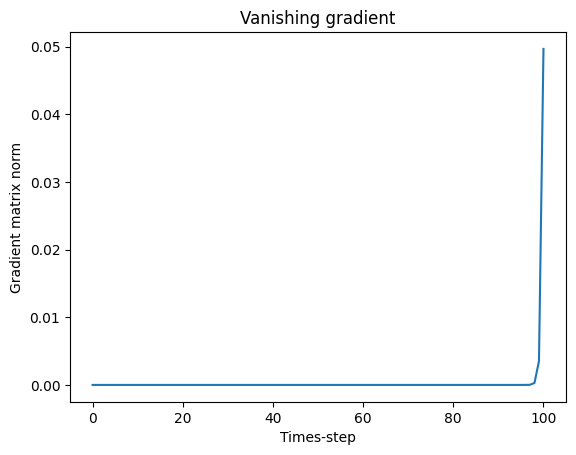

In [8]:
plt.plot(range(len(norm)), norm)
plt.title('Vanishing gradient')
plt.xlabel('Times-step')
plt.ylabel('Gradient matrix norm')

### Exploding problem

In [9]:
# Initialize RNN model with large weights
rnn = RNN(100, 2)

# Forward
out, _ = rnn.forward(X)
probs = softmax(out)

# Build dL/dy
d_L_d_y = probs
d_L_d_y[y] -= 1

# Backward
grads = rnn.backprop(d_L_d_y)

In [10]:
norm = [np.linalg.norm(grad, 'fro') for grad in grads]
norm.reverse()
print(norm)

[26132354954031.61, 15147694682152.715, 8084393849064.875, 5972415528601.828, 3173819626242.1685, 2188334054325.396, 1070120092925.1354, 835801625062.6884, 599727043485.7738, 427717853015.572, 378235529993.5306, 233698939176.67078, 100063306579.95238, 42413636131.25107, 21232286248.787914, 9249574445.30121, 7807047671.85491, 4166432989.925474, 4272641003.7737784, 3466135031.5199356, 2588698954.7109056, 2037896848.5530643, 1183766940.2179096, 781890151.8170605, 409484967.5663961, 233759932.4876017, 104981005.4454592, 188016612.83639732, 66641150.03420438, 72013528.163753, 49550134.20947304, 148611256.19098693, 167467373.96987835, 150508411.11228406, 198121691.8218213, 89627825.4055957, 77582329.40976201, 42941372.7393394, 27443638.12121441, 9653640.745032938, 7314189.781271005, 3327445.0935883597, 9356083.893394783, 4636366.114953263, 4945378.527071128, 1760820.4602861346, 794086.7692919141, 366329.0926560723, 168455.3970708785, 426685.4489299542, 440226.74340710824, 782294.3328614708, 

Text(0, 0.5, 'Gradient matrix norm')

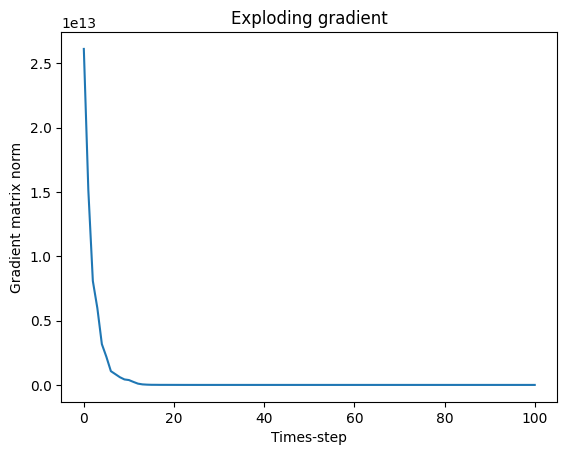

In [11]:
plt.plot(range(len(norm)), norm)
plt.title('Exploding gradient')
plt.xlabel('Times-step')
plt.ylabel('Gradient matrix norm')